In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
root_path = "/content/drive/Shareddrives/ARV_HACKATHON/Varuna Hackathon 2022"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install

In [3]:
!ls "$root_path"

 Grid_AOI	       sentinel-2-image   training_area
'Presentation Slide'   testing_area


In [4]:
!pip install rasterio
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 558 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 13.7 MB/s 
     |████████████████████████████████| 16.7 MB 65.2 MB/s 
     |████████████████████████████████| 6.3 MB 51.9 MB/s 


In [5]:
import rasterio
import rasterio.mask
import geopandas as gpd

import matplotlib.pyplot as plt
from rasterio import plot


In [6]:
path_2021 = f'{root_path}/sentinel-2-image/2021'
path_2020 = f'{root_path}/sentinel-2-image/2020'

In [7]:
def read_band(year_path, date, band_name):
    date_path = f'{year_path}/{date}'
    band_path = f'{date_path}/IMG_DATA/47PQS_{date}_{band_name}.jp2'
    band = rasterio.open(band_path)
    return band

In [8]:
train_shape = gpd.read_file(f'{root_path}/training_area/traindata.shp')
test_shape = gpd.read_file(f'{root_path}/testing_area/testdata.shp')

train_crs = train_shape.to_crs({'init': 'epsg:32647'})
test_crs = test_shape.to_crs({'init': 'epsg:32647'})

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [9]:
date = '20210101'
band2 = read_band(path_2021, date, 'B02')
band3 = read_band(path_2021, date, 'B03')
band4 = read_band(path_2021, date, 'B04')

In [10]:
aoi = read_band(path_2021, date, 'AOT')
scl = read_band(path_2021, date, 'SCL')

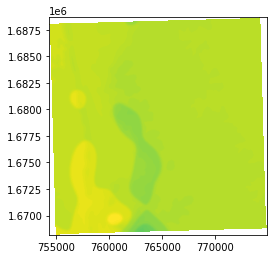

In [11]:
plot.show(aoi, transform=aoi.transform)

In [12]:
with rasterio.open(f'{date}.tiff','w',driver='Gtiff', width=band4.width, height=band4.height, 
              count=5,crs=band4.crs,transform=band4.transform, dtype=band4.dtypes[0]) as rgb:
    rgb.write(band2.read(1),1) 
    rgb.write(band3.read(1),2) 
    rgb.write(band4.read(1),3) 
    #rgb.write(aoi.read(1),4)
    #rgb.write(scl.read(1),5)  
    rgb.close()

In [13]:
with rasterio.open(f'{date}.tiff') as src:
    out_image, out_transform = rasterio.mask.mask(src, train_crs.geometry, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rasterio.open(f'{date}-RGB_masked.tif', "w", **out_meta) as dest:
    dest.write(out_image)

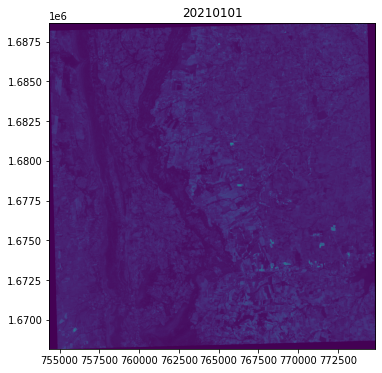

In [14]:
src = rasterio.open('20210101.tiff')
plt.figure(figsize=(6, 6))
plt.title('20210101')
plot.show(src, transform=src.transform)

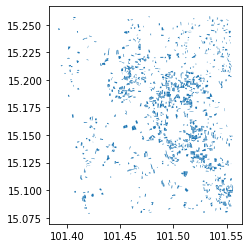

In [15]:
train_shape = train_shape.to_crs("EPSG:4326")
train_shape.geometry.plot()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


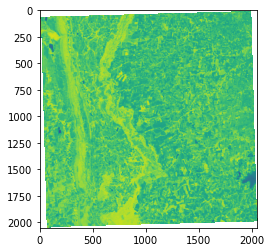

In [16]:
band8 = read_band(path_2021, date, 'B08').read(1).astype(float)
band4 = read_band(path_2021, date, 'B04').read(1).astype(float)
NDVI = (band8 - band4) / (band8 + band4)
plot.show(NDVI)

In [17]:
import numpy as np
np.unique(NDVI)

array([-1.        , -0.91666667, -0.90909091, ...,  0.94736842,
        1.        ,         nan])

In [18]:
from xml.dom import minidom

metadata_path = f'{path_2021}/{date}/metadata.xml'
xmldoc = minidom.parse(metadata_path)
nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

In [21]:
src.dataset_mask()

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [22]:
def SCL_converter(jp2):
  ds = rasterio.open(jp2)
  dat_array=ds.read(1)
  dict_label={}

  for i in range(0,13):
    dict_label[i]=(dat_array == i).sum()

  return dat_array,dict_label

def SCL_carray_conv(arr):
  dict_label={}

  for i in range(0,13):
    dict_label[i]=(arr == i).sum()  


  return dict_label


dar=SCL_converter(r"/content/drive/Shareddrives/ARV_HACKATHON/Varuna Hackathon 2022/sentinel-2-image/2021/20210101/IMG_DATA/47PQS_20210101_SCL.jp2")

# pd.DataFrame.from_dict(dar[1],orient='index').T


In [23]:
def scale_x(x):

  res=(x-754360)*(1025/20500)

  return int(res)
def scale_y(y):

  res=(y-1668180)*(1025/20500)

  return int(res)

# Run

In [24]:
import geopandas as gpd

df_test=gpd.read_file("/content/drive/Shareddrives/ARV_HACKATHON/Varuna Hackathon 2022/testing_area/testdata.shp")
df_test["X_cen"]=df_test.centroid.x
df_test["Y_cen"]=df_test.centroid.y
df_test["conx"]=df_test["X_cen"].apply(scale_x)
df_test["cony"]=df_test["Y_cen"].apply(scale_y)
df_test

,years,geometry,X_cen,Y_cen,conx,cony
0,2021,"POLYGON ((757423.308 1685327.647, 757426.291 1...",757488.625831,1.685375e+06,156,859
1,2021,"POLYGON ((767742.809 1676232.845, 767827.538 1...",767787.113695,1.676206e+06,671,401
2,2021,"POLYGON ((772184.324 1684618.508, 772189.637 1...",772163.480881,1.684549e+06,890,818
3,2021,"POLYGON ((773249.531 1683829.873, 773384.343 1...",773329.083836,1.683828e+06,948,782
4,2021,"POLYGON ((772834.902 1670561.878, 772844.892 1...",772869.375072,1.670656e+06,925,123
...,...,...,...,...,...,...
560,2021,"POLYGON ((765232.017 1669738.988, 765300.407 1...",765228.065410,1.669646e+06,543,73
561,2021,"POLYGON ((766193.230 1670482.458, 766188.792 1...",766140.920295,1.670336e+06,589,107
562,2021,"POLYGON ((764212.922 1682017.688, 764070.965 1...",764081.779773,1.681977e+06,486,689
563,2021,"POLYGON ((763019.219 1680315.869, 762993.636 1...",762985.890738,1.680171e+06,431,599


In [36]:
# import os 
# import pandas as pd
# root_folder="/content/drive/Shareddrives/ARV_HACKATHON/Varuna Hackathon 2022/sentinel-2-image/2021/"

# list_of_date=os.listdir(root_folder)

# # for i in list_of_date[:10]:
# #   if i.startswith('202101'):
# name_interset=[]
# array_list_interest=[]
# for i in list_of_date:
#   if i.startswith('202112'):
  
#     path_folder=root_folder+i+"/IMG_DATA/"
#     list_of_scl=os.listdir(path_folder)
#   #print(list_of_scl)

#     for j in list_of_scl:
#       if (".jp2" in j) and ("SCL" in j) and (".xml" not in j):
#         dat_path=root_folder+i+"/IMG_DATA/"+j
#         dar=SCL_converter(dat_path)

#         print(j)
#         print(dat_path)
#         name_interset.append(dat_path)
#         array_list_interest.append(dar[0])
#         display(plot.show(dar[0]))
#         display(pd.DataFrame.from_dict(dar[1],orient='index').T)

In [60]:
def filter_scl(arr):
  mem=[]
  for i in arr:
    if int(i)==4 or int(i)==5 or int(i)==6 or int(i)==7:
      mem.append(i)
    else:
      pass
  return mem

def mode_2(arr):
  mem=[]
  c=0
  set_=set(arr)
  for i in set_:
    c1=arr.count(i)
    if c1==c:
      mem.append(i)
      c=c1
    elif c1>c:
      mem=[i]
      c=c1
    else:
      pass
  return mem



In [43]:
import os 
import pandas as pd
root_folder="/content/drive/Shareddrives/ARV_HACKATHON/Varuna Hackathon 2022/sentinel-2-image/2021/"

list_of_date=os.listdir(root_folder)

# for i in list_of_date[:10]:
#   if i.startswith('202101'):
name_interset=[]
array_list_interest=[]
for i in list_of_date:
  if i.startswith('202101'):
  
    path_folder=root_folder+i+"/IMG_DATA/"
    list_of_scl=os.listdir(path_folder)
  #print(list_of_scl)

    for j in list_of_scl:
      if (".jp2" in j) and ("SCL" in j) and (".xml" not in j):
        dat_path=root_folder+i+"/IMG_DATA/"+j
        dar=SCL_converter(dat_path)

        #print(j)
        #print(dat_path)
        name_interset.append(dat_path)
        array_list_interest.append(dar[0])
        #display(plot.show(dar[0]))
        #display(pd.DataFrame.from_dict(dar[1],orient='index').T)

my_rows, my_cols = (1025, 1025)
my_array = [[0]*my_cols]*my_rows
my_array=np.array(my_array)
#print(my_array)



from tqdm import tqdm 

for j in tqdm(range(1025)):
  for k in range(1025):
    list_mode=[]
    for i in range(len(array_list_interest)):
      list_mode.append(array_list_interest[i][j][k])
    #print(list_mode)
    if filter_scl(list_mode)==[]:
      #print("here")
      pass
    else:
      list_mode=filter_scl(list_mode)


    my_array[j][k]=mode_2(list_mode)[0]

    


lis=[]
for i,j in zip(df_test.conx,df_test.cony):
  lis.append(my_array[i][j])



df_test["m_1"]=lis
df_test.head()


100%|██████████| 1025/1025 [00:14<00:00, 68.92it/s]


,years,geometry,X_cen,Y_cen,conx,cony,m_1
0,2021,"POLYGON ((757423.308 1685327.647, 757426.291 1...",757488.625831,1.685375e+06,156,859,5
1,2021,"POLYGON ((767742.809 1676232.845, 767827.538 1...",767787.113695,1.676206e+06,671,401,5
2,2021,"POLYGON ((772184.324 1684618.508, 772189.637 1...",772163.480881,1.684549e+06,890,818,4
3,2021,"POLYGON ((773249.531 1683829.873, 773384.343 1...",773329.083836,1.683828e+06,948,782,5
4,2021,"POLYGON ((772834.902 1670561.878, 772844.892 1...",772869.375072,1.670656e+06,925,123,4


In [44]:
import os 
import pandas as pd
root_folder="/content/drive/Shareddrives/ARV_HACKATHON/Varuna Hackathon 2022/sentinel-2-image/2021/"

list_of_date=os.listdir(root_folder)

# for i in list_of_date[:10]:
#   if i.startswith('202101'):
name_interset=[]
array_list_interest=[]
for i in list_of_date:
  if i.startswith('202102'):
  
    path_folder=root_folder+i+"/IMG_DATA/"
    list_of_scl=os.listdir(path_folder)
  #print(list_of_scl)

    for j in list_of_scl:
      if (".jp2" in j) and ("SCL" in j) and (".xml" not in j):
        dat_path=root_folder+i+"/IMG_DATA/"+j
        dar=SCL_converter(dat_path)

        #print(j)
        #print(dat_path)
        name_interset.append(dat_path)
        array_list_interest.append(dar[0])
        #display(plot.show(dar[0]))
        #display(pd.DataFrame.from_dict(dar[1],orient='index').T)

my_rows, my_cols = (1025, 1025)
my_array = [[0]*my_cols]*my_rows
my_array=np.array(my_array)
#print(my_array)



from tqdm import tqdm 

for j in tqdm(range(1025)):
  for k in range(1025):
    list_mode=[]
    for i in range(len(array_list_interest)):
      list_mode.append(array_list_interest[i][j][k])
    #print(list_mode)
    if filter_scl(list_mode)==[]:
      #print("here")
      pass
    else:
      list_mode=filter_scl(list_mode)


    my_array[j][k]=mode_2(list_mode)[0]

    


lis=[]
for i,j in zip(df_test.conx,df_test.cony):
  lis.append(my_array[i][j])



df_test["m_2"]=lis
df_test.head()


100%|██████████| 1025/1025 [00:09<00:00, 107.76it/s]


,years,geometry,X_cen,Y_cen,conx,cony,m_1,m_2
0,2021,"POLYGON ((757423.308 1685327.647, 757426.291 1...",757488.625831,1.685375e+06,156,859,5,5
1,2021,"POLYGON ((767742.809 1676232.845, 767827.538 1...",767787.113695,1.676206e+06,671,401,5,5
2,2021,"POLYGON ((772184.324 1684618.508, 772189.637 1...",772163.480881,1.684549e+06,890,818,4,5
3,2021,"POLYGON ((773249.531 1683829.873, 773384.343 1...",773329.083836,1.683828e+06,948,782,5,5
4,2021,"POLYGON ((772834.902 1670561.878, 772844.892 1...",772869.375072,1.670656e+06,925,123,4,5


In [45]:
import os 
import pandas as pd
root_folder="/content/drive/Shareddrives/ARV_HACKATHON/Varuna Hackathon 2022/sentinel-2-image/2021/"

list_of_date=os.listdir(root_folder)

# for i in list_of_date[:10]:
#   if i.startswith('202101'):
name_interset=[]
array_list_interest=[]
for i in list_of_date:
  if i.startswith('202103'):
  
    path_folder=root_folder+i+"/IMG_DATA/"
    list_of_scl=os.listdir(path_folder)
  #print(list_of_scl)

    for j in list_of_scl:
      if (".jp2" in j) and ("SCL" in j) and (".xml" not in j):
        dat_path=root_folder+i+"/IMG_DATA/"+j
        dar=SCL_converter(dat_path)

        #print(j)
        #print(dat_path)
        name_interset.append(dat_path)
        array_list_interest.append(dar[0])
        #display(plot.show(dar[0]))
        #display(pd.DataFrame.from_dict(dar[1],orient='index').T)

my_rows, my_cols = (1025, 1025)
my_array = [[0]*my_cols]*my_rows
my_array=np.array(my_array)
#print(my_array)



from tqdm import tqdm 

for j in tqdm(range(1025)):
  for k in range(1025):
    list_mode=[]
    for i in range(len(array_list_interest)):
      list_mode.append(array_list_interest[i][j][k])
    #print(list_mode)
    if filter_scl(list_mode)==[]:
      #print("here")
      pass
    else:
      list_mode=filter_scl(list_mode)


    my_array[j][k]=mode_2(list_mode)[0]

    


lis=[]
for i,j in zip(df_test.conx,df_test.cony):
  lis.append(my_array[i][j])



df_test["m_3"]=lis
df_test.head()


100%|██████████| 1025/1025 [00:12<00:00, 84.70it/s]


,years,geometry,X_cen,Y_cen,conx,cony,m_1,m_2,m_3
0,2021,"POLYGON ((757423.308 1685327.647, 757426.291 1...",757488.625831,1.685375e+06,156,859,5,5,5
1,2021,"POLYGON ((767742.809 1676232.845, 767827.538 1...",767787.113695,1.676206e+06,671,401,5,5,5
2,2021,"POLYGON ((772184.324 1684618.508, 772189.637 1...",772163.480881,1.684549e+06,890,818,4,5,5
3,2021,"POLYGON ((773249.531 1683829.873, 773384.343 1...",773329.083836,1.683828e+06,948,782,5,5,5
4,2021,"POLYGON ((772834.902 1670561.878, 772844.892 1...",772869.375072,1.670656e+06,925,123,4,5,5


In [46]:
import os 
import pandas as pd
root_folder="/content/drive/Shareddrives/ARV_HACKATHON/Varuna Hackathon 2022/sentinel-2-image/2021/"

list_of_date=os.listdir(root_folder)

# for i in list_of_date[:10]:
#   if i.startswith('202101'):
name_interset=[]
array_list_interest=[]
for i in list_of_date:
  if i.startswith('202104'):
  
    path_folder=root_folder+i+"/IMG_DATA/"
    list_of_scl=os.listdir(path_folder)
  #print(list_of_scl)

    for j in list_of_scl:
      if (".jp2" in j) and ("SCL" in j) and (".xml" not in j):
        dat_path=root_folder+i+"/IMG_DATA/"+j
        dar=SCL_converter(dat_path)

        #print(j)
        #print(dat_path)
        name_interset.append(dat_path)
        array_list_interest.append(dar[0])
        #display(plot.show(dar[0]))
        #display(pd.DataFrame.from_dict(dar[1],orient='index').T)

my_rows, my_cols = (1025, 1025)
my_array = [[0]*my_cols]*my_rows
my_array=np.array(my_array)
#print(my_array)



from tqdm import tqdm 

for j in tqdm(range(1025)):
  for k in range(1025):
    list_mode=[]
    for i in range(len(array_list_interest)):
      list_mode.append(array_list_interest[i][j][k])
    #print(list_mode)
    if filter_scl(list_mode)==[]:
      #print("here")
      pass
    else:
      list_mode=filter_scl(list_mode)


    my_array[j][k]=mode_2(list_mode)[0]

    


lis=[]
for i,j in zip(df_test.conx,df_test.cony):
  lis.append(my_array[i][j])



df_test["m_4"]=lis
df_test.head()


100%|██████████| 1025/1025 [00:12<00:00, 79.73it/s]


,years,geometry,X_cen,Y_cen,conx,cony,m_1,m_2,m_3,m_4
0,2021,"POLYGON ((757423.308 1685327.647, 757426.291 1...",757488.625831,1.685375e+06,156,859,5,5,5,4
1,2021,"POLYGON ((767742.809 1676232.845, 767827.538 1...",767787.113695,1.676206e+06,671,401,5,5,5,4
2,2021,"POLYGON ((772184.324 1684618.508, 772189.637 1...",772163.480881,1.684549e+06,890,818,4,5,5,4
3,2021,"POLYGON ((773249.531 1683829.873, 773384.343 1...",773329.083836,1.683828e+06,948,782,5,5,5,5
4,2021,"POLYGON ((772834.902 1670561.878, 772844.892 1...",772869.375072,1.670656e+06,925,123,4,5,5,4


In [47]:
import os 
import pandas as pd
root_folder="/content/drive/Shareddrives/ARV_HACKATHON/Varuna Hackathon 2022/sentinel-2-image/2021/"

list_of_date=os.listdir(root_folder)

# for i in list_of_date[:10]:
#   if i.startswith('202101'):
name_interset=[]
array_list_interest=[]
for i in list_of_date:
  if i.startswith('202105'):
  
    path_folder=root_folder+i+"/IMG_DATA/"
    list_of_scl=os.listdir(path_folder)
  #print(list_of_scl)

    for j in list_of_scl:
      if (".jp2" in j) and ("SCL" in j) and (".xml" not in j):
        dat_path=root_folder+i+"/IMG_DATA/"+j
        dar=SCL_converter(dat_path)

        #print(j)
        #print(dat_path)
        name_interset.append(dat_path)
        array_list_interest.append(dar[0])
        #display(plot.show(dar[0]))
        #display(pd.DataFrame.from_dict(dar[1],orient='index').T)

my_rows, my_cols = (1025, 1025)
my_array = [[0]*my_cols]*my_rows
my_array=np.array(my_array)
#print(my_array)



from tqdm import tqdm 

for j in tqdm(range(1025)):
  for k in range(1025):
    list_mode=[]
    for i in range(len(array_list_interest)):
      list_mode.append(array_list_interest[i][j][k])
    #print(list_mode)
    if filter_scl(list_mode)==[]:
      #print("here")
      pass
    else:
      list_mode=filter_scl(list_mode)


    my_array[j][k]=mode_2(list_mode)[0]

    


lis=[]
for i,j in zip(df_test.conx,df_test.cony):
  lis.append(my_array[i][j])



df_test["m_5"]=lis
df_test.head()


100%|██████████| 1025/1025 [00:18<00:00, 56.52it/s]


,years,geometry,X_cen,Y_cen,conx,cony,m_1,m_2,m_3,m_4,m_5
0,2021,"POLYGON ((757423.308 1685327.647, 757426.291 1...",757488.625831,1.685375e+06,156,859,5,5,5,4,4
1,2021,"POLYGON ((767742.809 1676232.845, 767827.538 1...",767787.113695,1.676206e+06,671,401,5,5,5,4,4
2,2021,"POLYGON ((772184.324 1684618.508, 772189.637 1...",772163.480881,1.684549e+06,890,818,4,5,5,4,4
3,2021,"POLYGON ((773249.531 1683829.873, 773384.343 1...",773329.083836,1.683828e+06,948,782,5,5,5,5,4
4,2021,"POLYGON ((772834.902 1670561.878, 772844.892 1...",772869.375072,1.670656e+06,925,123,4,5,5,4,7


In [48]:
import os 
import pandas as pd
root_folder="/content/drive/Shareddrives/ARV_HACKATHON/Varuna Hackathon 2022/sentinel-2-image/2021/"

list_of_date=os.listdir(root_folder)

# for i in list_of_date[:10]:
#   if i.startswith('202101'):
name_interset=[]
array_list_interest=[]
for i in list_of_date:
  if i.startswith('202106'):
  
    path_folder=root_folder+i+"/IMG_DATA/"
    list_of_scl=os.listdir(path_folder)
  #print(list_of_scl)

    for j in list_of_scl:
      if (".jp2" in j) and ("SCL" in j) and (".xml" not in j):
        dat_path=root_folder+i+"/IMG_DATA/"+j
        dar=SCL_converter(dat_path)

        #print(j)
        #print(dat_path)
        name_interset.append(dat_path)
        array_list_interest.append(dar[0])
        #display(plot.show(dar[0]))
        #display(pd.DataFrame.from_dict(dar[1],orient='index').T)

my_rows, my_cols = (1025, 1025)
my_array = [[0]*my_cols]*my_rows
my_array=np.array(my_array)
#print(my_array)



from tqdm import tqdm 

for j in tqdm(range(1025)):
  for k in range(1025):
    list_mode=[]
    for i in range(len(array_list_interest)):
      list_mode.append(array_list_interest[i][j][k])
    #print(list_mode)
    if filter_scl(list_mode)==[]:
      #print("here")
      pass
    else:
      list_mode=filter_scl(list_mode)


    my_array[j][k]=mode_2(list_mode)[0]

    


lis=[]
for i,j in zip(df_test.conx,df_test.cony):
  lis.append(my_array[i][j])



df_test["m_6"]=lis
df_test.head()


100%|██████████| 1025/1025 [00:16<00:00, 60.67it/s]


,years,geometry,X_cen,Y_cen,conx,cony,m_1,m_2,m_3,m_4,m_5,m_6
0,2021,"POLYGON ((757423.308 1685327.647, 757426.291 1...",757488.625831,1.685375e+06,156,859,5,5,5,4,4,4
1,2021,"POLYGON ((767742.809 1676232.845, 767827.538 1...",767787.113695,1.676206e+06,671,401,5,5,5,4,4,4
2,2021,"POLYGON ((772184.324 1684618.508, 772189.637 1...",772163.480881,1.684549e+06,890,818,4,5,5,4,4,4
3,2021,"POLYGON ((773249.531 1683829.873, 773384.343 1...",773329.083836,1.683828e+06,948,782,5,5,5,5,4,4
4,2021,"POLYGON ((772834.902 1670561.878, 772844.892 1...",772869.375072,1.670656e+06,925,123,4,5,5,4,7,5


In [49]:
import os 
import pandas as pd
root_folder="/content/drive/Shareddrives/ARV_HACKATHON/Varuna Hackathon 2022/sentinel-2-image/2021/"

list_of_date=os.listdir(root_folder)

# for i in list_of_date[:10]:
#   if i.startswith('202101'):
name_interset=[]
array_list_interest=[]
for i in list_of_date:
  if i.startswith('202107'):
  
    path_folder=root_folder+i+"/IMG_DATA/"
    list_of_scl=os.listdir(path_folder)
  #print(list_of_scl)

    for j in list_of_scl:
      if (".jp2" in j) and ("SCL" in j) and (".xml" not in j):
        dat_path=root_folder+i+"/IMG_DATA/"+j
        dar=SCL_converter(dat_path)

        #print(j)
        #print(dat_path)
        name_interset.append(dat_path)
        array_list_interest.append(dar[0])
        #display(plot.show(dar[0]))
        #display(pd.DataFrame.from_dict(dar[1],orient='index').T)

my_rows, my_cols = (1025, 1025)
my_array = [[0]*my_cols]*my_rows
my_array=np.array(my_array)
#print(my_array)



from tqdm import tqdm 

for j in tqdm(range(1025)):
  for k in range(1025):
    list_mode=[]
    for i in range(len(array_list_interest)):
      list_mode.append(array_list_interest[i][j][k])
    #print(list_mode)
    if filter_scl(list_mode)==[]:
      #print("here")
      pass
    else:
      list_mode=filter_scl(list_mode)


    my_array[j][k]=mode_2(list_mode)[0]

    


lis=[]
for i,j in zip(df_test.conx,df_test.cony):
  lis.append(my_array[i][j])



df_test["m_7"]=lis
df_test.head()


100%|██████████| 1025/1025 [00:17<00:00, 58.60it/s]


,years,geometry,X_cen,Y_cen,conx,cony,m_1,m_2,m_3,m_4,m_5,m_6,m_7
0,2021,"POLYGON ((757423.308 1685327.647, 757426.291 1...",757488.625831,1.685375e+06,156,859,5,5,5,4,4,4,5
1,2021,"POLYGON ((767742.809 1676232.845, 767827.538 1...",767787.113695,1.676206e+06,671,401,5,5,5,4,4,4,4
2,2021,"POLYGON ((772184.324 1684618.508, 772189.637 1...",772163.480881,1.684549e+06,890,818,4,5,5,4,4,4,4
3,2021,"POLYGON ((773249.531 1683829.873, 773384.343 1...",773329.083836,1.683828e+06,948,782,5,5,5,5,4,4,4
4,2021,"POLYGON ((772834.902 1670561.878, 772844.892 1...",772869.375072,1.670656e+06,925,123,4,5,5,4,7,5,4


In [50]:
import os 
import pandas as pd
root_folder="/content/drive/Shareddrives/ARV_HACKATHON/Varuna Hackathon 2022/sentinel-2-image/2021/"

list_of_date=os.listdir(root_folder)

# for i in list_of_date[:10]:
#   if i.startswith('202101'):
name_interset=[]
array_list_interest=[]
for i in list_of_date:
  if i.startswith('202108'):
  
    path_folder=root_folder+i+"/IMG_DATA/"
    list_of_scl=os.listdir(path_folder)
  #print(list_of_scl)

    for j in list_of_scl:
      if (".jp2" in j) and ("SCL" in j) and (".xml" not in j):
        dat_path=root_folder+i+"/IMG_DATA/"+j
        dar=SCL_converter(dat_path)

        #print(j)
        #print(dat_path)
        name_interset.append(dat_path)
        array_list_interest.append(dar[0])
        #display(plot.show(dar[0]))
        #display(pd.DataFrame.from_dict(dar[1],orient='index').T)

my_rows, my_cols = (1025, 1025)
my_array = [[0]*my_cols]*my_rows
my_array=np.array(my_array)
#print(my_array)



from tqdm import tqdm 

for j in tqdm(range(1025)):
  for k in range(1025):
    list_mode=[]
    for i in range(len(array_list_interest)):
      list_mode.append(array_list_interest[i][j][k])
    #print(list_mode)
    if filter_scl(list_mode)==[]:
      #print("here")
      pass
    else:
      list_mode=filter_scl(list_mode)


    my_array[j][k]=mode_2(list_mode)[0]

    


lis=[]
for i,j in zip(df_test.conx,df_test.cony):
  lis.append(my_array[i][j])



df_test["m_8"]=lis
df_test.head()


100%|██████████| 1025/1025 [00:11<00:00, 88.80it/s]


,years,geometry,X_cen,Y_cen,conx,cony,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8
0,2021,"POLYGON ((757423.308 1685327.647, 757426.291 1...",757488.625831,1.685375e+06,156,859,5,5,5,4,4,4,5,4
1,2021,"POLYGON ((767742.809 1676232.845, 767827.538 1...",767787.113695,1.676206e+06,671,401,5,5,5,4,4,4,4,4
2,2021,"POLYGON ((772184.324 1684618.508, 772189.637 1...",772163.480881,1.684549e+06,890,818,4,5,5,4,4,4,4,5
3,2021,"POLYGON ((773249.531 1683829.873, 773384.343 1...",773329.083836,1.683828e+06,948,782,5,5,5,5,4,4,4,9
4,2021,"POLYGON ((772834.902 1670561.878, 772844.892 1...",772869.375072,1.670656e+06,925,123,4,5,5,4,7,5,4,4


In [51]:
import os 
import pandas as pd
root_folder="/content/drive/Shareddrives/ARV_HACKATHON/Varuna Hackathon 2022/sentinel-2-image/2021/"

list_of_date=os.listdir(root_folder)

# for i in list_of_date[:10]:
#   if i.startswith('202101'):
name_interset=[]
array_list_interest=[]
for i in list_of_date:
  if i.startswith('202109'):
  
    path_folder=root_folder+i+"/IMG_DATA/"
    list_of_scl=os.listdir(path_folder)
  #print(list_of_scl)

    for j in list_of_scl:
      if (".jp2" in j) and ("SCL" in j) and (".xml" not in j):
        dat_path=root_folder+i+"/IMG_DATA/"+j
        dar=SCL_converter(dat_path)

        #print(j)
        #print(dat_path)
        name_interset.append(dat_path)
        array_list_interest.append(dar[0])
        #display(plot.show(dar[0]))
        #display(pd.DataFrame.from_dict(dar[1],orient='index').T)

my_rows, my_cols = (1025, 1025)
my_array = [[0]*my_cols]*my_rows
my_array=np.array(my_array)
#print(my_array)



from tqdm import tqdm 

for j in tqdm(range(1025)):
  for k in range(1025):
    list_mode=[]
    for i in range(len(array_list_interest)):
      list_mode.append(array_list_interest[i][j][k])
    #print(list_mode)
    if filter_scl(list_mode)==[]:
      #print("here")
      pass
    else:
      list_mode=filter_scl(list_mode)


    my_array[j][k]=mode_2(list_mode)[0]

    


lis=[]
for i,j in zip(df_test.conx,df_test.cony):
  lis.append(my_array[i][j])



df_test["m_9"]=lis
df_test.head()


100%|██████████| 1025/1025 [00:14<00:00, 70.55it/s]


,years,geometry,X_cen,Y_cen,conx,cony,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9
0,2021,"POLYGON ((757423.308 1685327.647, 757426.291 1...",757488.625831,1.685375e+06,156,859,5,5,5,4,4,4,5,4,4
1,2021,"POLYGON ((767742.809 1676232.845, 767827.538 1...",767787.113695,1.676206e+06,671,401,5,5,5,4,4,4,4,4,4
2,2021,"POLYGON ((772184.324 1684618.508, 772189.637 1...",772163.480881,1.684549e+06,890,818,4,5,5,4,4,4,4,5,6
3,2021,"POLYGON ((773249.531 1683829.873, 773384.343 1...",773329.083836,1.683828e+06,948,782,5,5,5,5,4,4,4,9,4
4,2021,"POLYGON ((772834.902 1670561.878, 772844.892 1...",772869.375072,1.670656e+06,925,123,4,5,5,4,7,5,4,4,7


In [52]:
import os 
import pandas as pd
root_folder="/content/drive/Shareddrives/ARV_HACKATHON/Varuna Hackathon 2022/sentinel-2-image/2021/"

list_of_date=os.listdir(root_folder)

# for i in list_of_date[:10]:
#   if i.startswith('202101'):
name_interset=[]
array_list_interest=[]
for i in list_of_date:
  if i.startswith('202110'):
  
    path_folder=root_folder+i+"/IMG_DATA/"
    list_of_scl=os.listdir(path_folder)
  #print(list_of_scl)

    for j in list_of_scl:
      if (".jp2" in j) and ("SCL" in j) and (".xml" not in j):
        dat_path=root_folder+i+"/IMG_DATA/"+j
        dar=SCL_converter(dat_path)

        #print(j)
        #print(dat_path)
        name_interset.append(dat_path)
        array_list_interest.append(dar[0])
        #display(plot.show(dar[0]))
        #display(pd.DataFrame.from_dict(dar[1],orient='index').T)

my_rows, my_cols = (1025, 1025)
my_array = [[0]*my_cols]*my_rows
my_array=np.array(my_array)
#print(my_array)



from tqdm import tqdm 

for j in tqdm(range(1025)):
  for k in range(1025):
    list_mode=[]
    for i in range(len(array_list_interest)):
      list_mode.append(array_list_interest[i][j][k])
    #print(list_mode)
    if filter_scl(list_mode)==[]:
      #print("here")
      pass
    else:
      list_mode=filter_scl(list_mode)


    my_array[j][k]=mode_2(list_mode)[0]

    


lis=[]
for i,j in zip(df_test.conx,df_test.cony):
  lis.append(my_array[i][j])



df_test["m_10"]=lis
df_test.head()


100%|██████████| 1025/1025 [00:11<00:00, 87.69it/s]


,years,geometry,X_cen,Y_cen,conx,cony,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10
0,2021,"POLYGON ((757423.308 1685327.647, 757426.291 1...",757488.625831,1.685375e+06,156,859,5,5,5,4,4,4,5,4,4,4
1,2021,"POLYGON ((767742.809 1676232.845, 767827.538 1...",767787.113695,1.676206e+06,671,401,5,5,5,4,4,4,4,4,4,4
2,2021,"POLYGON ((772184.324 1684618.508, 772189.637 1...",772163.480881,1.684549e+06,890,818,4,5,5,4,4,4,4,5,6,4
3,2021,"POLYGON ((773249.531 1683829.873, 773384.343 1...",773329.083836,1.683828e+06,948,782,5,5,5,5,4,4,4,9,4,4
4,2021,"POLYGON ((772834.902 1670561.878, 772844.892 1...",772869.375072,1.670656e+06,925,123,4,5,5,4,7,5,4,4,7,4


In [53]:
import os 
import pandas as pd
root_folder="/content/drive/Shareddrives/ARV_HACKATHON/Varuna Hackathon 2022/sentinel-2-image/2021/"

list_of_date=os.listdir(root_folder)

# for i in list_of_date[:10]:
#   if i.startswith('202101'):
name_interset=[]
array_list_interest=[]
for i in list_of_date:
  if i.startswith('202111'):
  
    path_folder=root_folder+i+"/IMG_DATA/"
    list_of_scl=os.listdir(path_folder)
  #print(list_of_scl)

    for j in list_of_scl:
      if (".jp2" in j) and ("SCL" in j) and (".xml" not in j):
        dat_path=root_folder+i+"/IMG_DATA/"+j
        dar=SCL_converter(dat_path)

        #print(j)
        #print(dat_path)
        name_interset.append(dat_path)
        array_list_interest.append(dar[0])
        #display(plot.show(dar[0]))
        #display(pd.DataFrame.from_dict(dar[1],orient='index').T)

my_rows, my_cols = (1025, 1025)
my_array = [[0]*my_cols]*my_rows
my_array=np.array(my_array)
#print(my_array)



from tqdm import tqdm 

for j in tqdm(range(1025)):
  for k in range(1025):
    list_mode=[]
    for i in range(len(array_list_interest)):
      list_mode.append(array_list_interest[i][j][k])
    #print(list_mode)
    if filter_scl(list_mode)==[]:
      #print("here")
      pass
    else:
      list_mode=filter_scl(list_mode)


    my_array[j][k]=mode_2(list_mode)[0]

    


lis=[]
for i,j in zip(df_test.conx,df_test.cony):
  lis.append(my_array[i][j])



df_test["m_11"]=lis
df_test.head()


100%|██████████| 1025/1025 [00:09<00:00, 113.70it/s]


,years,geometry,X_cen,Y_cen,conx,cony,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11
0,2021,"POLYGON ((757423.308 1685327.647, 757426.291 1...",757488.625831,1.685375e+06,156,859,5,5,5,4,4,4,5,4,4,4,4
1,2021,"POLYGON ((767742.809 1676232.845, 767827.538 1...",767787.113695,1.676206e+06,671,401,5,5,5,4,4,4,4,4,4,4,4
2,2021,"POLYGON ((772184.324 1684618.508, 772189.637 1...",772163.480881,1.684549e+06,890,818,4,5,5,4,4,4,4,5,6,4,4
3,2021,"POLYGON ((773249.531 1683829.873, 773384.343 1...",773329.083836,1.683828e+06,948,782,5,5,5,5,4,4,4,9,4,4,5
4,2021,"POLYGON ((772834.902 1670561.878, 772844.892 1...",772869.375072,1.670656e+06,925,123,4,5,5,4,7,5,4,4,7,4,4


In [54]:
import os 
import pandas as pd
root_folder="/content/drive/Shareddrives/ARV_HACKATHON/Varuna Hackathon 2022/sentinel-2-image/2021/"

list_of_date=os.listdir(root_folder)

# for i in list_of_date[:10]:
#   if i.startswith('202101'):
name_interset=[]
array_list_interest=[]
for i in list_of_date:
  if i.startswith('202112'):
  
    path_folder=root_folder+i+"/IMG_DATA/"
    list_of_scl=os.listdir(path_folder)
  #print(list_of_scl)

    for j in list_of_scl:
      if (".jp2" in j) and ("SCL" in j) and (".xml" not in j):
        dat_path=root_folder+i+"/IMG_DATA/"+j
        dar=SCL_converter(dat_path)

        #print(j)
        #print(dat_path)
        name_interset.append(dat_path)
        array_list_interest.append(dar[0])
        #display(plot.show(dar[0]))
        #display(pd.DataFrame.from_dict(dar[1],orient='index').T)

my_rows, my_cols = (1025, 1025)
my_array = [[0]*my_cols]*my_rows
my_array=np.array(my_array)
#print(my_array)



from tqdm import tqdm 

for j in tqdm(range(1025)):
  for k in range(1025):
    list_mode=[]
    for i in range(len(array_list_interest)):
      list_mode.append(array_list_interest[i][j][k])
    #print(list_mode)
    if filter_scl(list_mode)==[]:
      #print("here")
      pass
    else:
      list_mode=filter_scl(list_mode)


    my_array[j][k]=mode_2(list_mode)[0]

    


lis=[]
for i,j in zip(df_test.conx,df_test.cony):
  lis.append(my_array[i][j])



df_test["m_12"]=lis
df_test.head()


100%|██████████| 1025/1025 [00:12<00:00, 82.52it/s] 


,years,geometry,X_cen,Y_cen,conx,cony,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12
0,2021,"POLYGON ((757423.308 1685327.647, 757426.291 1...",757488.625831,1.685375e+06,156,859,5,5,5,4,4,4,5,4,4,4,4,4
1,2021,"POLYGON ((767742.809 1676232.845, 767827.538 1...",767787.113695,1.676206e+06,671,401,5,5,5,4,4,4,4,4,4,4,4,4
2,2021,"POLYGON ((772184.324 1684618.508, 772189.637 1...",772163.480881,1.684549e+06,890,818,4,5,5,4,4,4,4,5,6,4,4,5
3,2021,"POLYGON ((773249.531 1683829.873, 773384.343 1...",773329.083836,1.683828e+06,948,782,5,5,5,5,4,4,4,9,4,4,5,5
4,2021,"POLYGON ((772834.902 1670561.878, 772844.892 1...",772869.375072,1.670656e+06,925,123,4,5,5,4,7,5,4,4,7,4,4,4


#result

In [55]:
df_test_sent=df_test.filter(like="m_", axis=1)
df_test_sent

,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12
0,5,5,5,4,4,4,5,4,4,4,4,4
1,5,5,5,4,4,4,4,4,4,4,4,4
2,4,5,5,4,4,4,4,5,6,4,4,5
3,5,5,5,5,4,4,4,9,4,4,5,5
4,4,5,5,4,7,5,4,4,7,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...
560,7,4,4,4,4,4,4,5,4,9,4,5
561,4,5,5,4,4,6,5,4,4,4,4,4
562,4,4,5,5,4,4,5,4,5,4,4,4
563,4,4,5,4,4,4,4,5,4,4,4,4


In [57]:
# df_tm=pd.read_csv("/content/test_max_evi_ndwi_savi_b1.csv")
# df_tm

In [58]:
# df_train_sent_join=pd.concat([df_tm,df_test_sent],axis=1)
# df_train_sent_join=df_train_sent_join.drop(columns="years")
# df_train_sent_join

In [59]:
# df_train_sent_join.to_csv("/content/submit_non_pred.csv",index=False)